## TODO
* Agregar la otra zona de ruido
* Agregar %%time a todo
* Verificar labels de ejes en gráficos ('GPS time')

In [1]:
import h5py
import numpy as np
import scipy.signal as sps
import matplotlib.pyplot as plt

In [2]:
def read_ligo(filename):
    f = h5py.File(filename, 'r')
    strain = f['strain/Strain'][...]
    fs = 1/ f['strain/Strain'].attrs['Xspacing']
    start_time = f['meta/GPSstart'][()]
    f.close()
    return strain, start_time, fs

In [3]:
# Open hdf5 files
h1_s, h1_st, h1_fs = read_ligo('../assets/data/h1_32sec_4khz.hdf5')
l1_s, l1_st, l1_fs = read_ligo('../assets/data/l1_32sec_4khz.hdf5')

In [4]:
event_start_gps = 1126259462
event_start = event_start_gps - h1_st
event_delta = 0.2
time = np.arange(0,h1_s.shape[0]/h1_fs, 1/h1_fs)

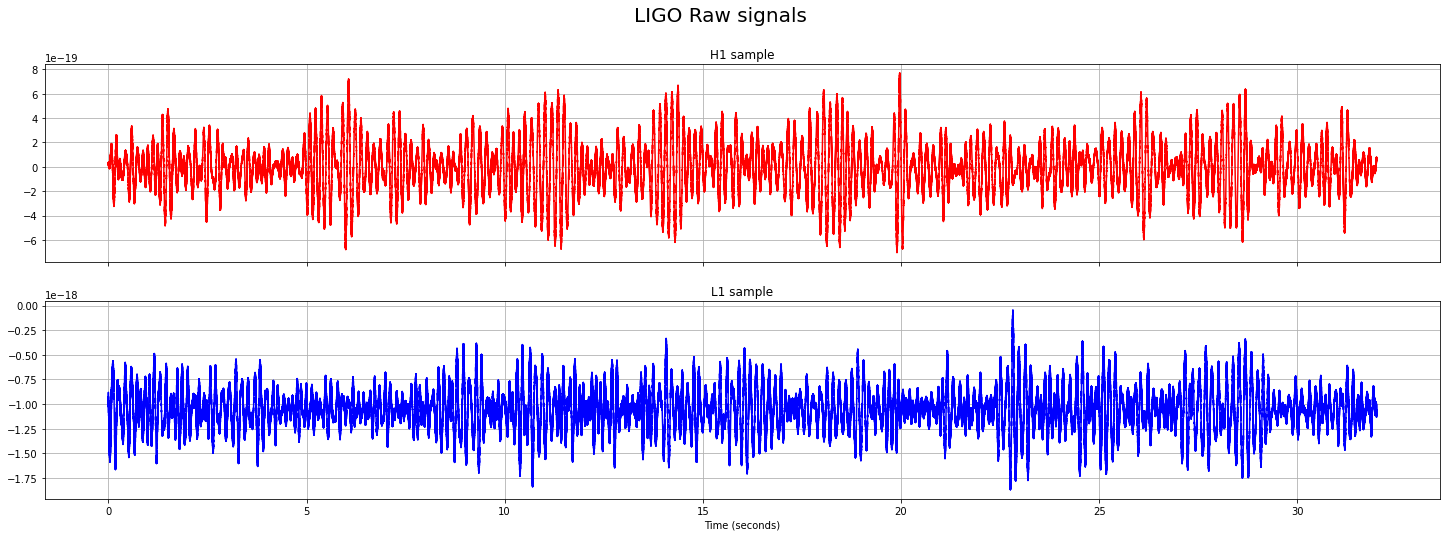

In [5]:
# Plot raw signals
fig, axs = plt.subplots(2, sharex=True, figsize=(25,8))
fig.suptitle('LIGO Raw signals', fontsize=20)
axs[0].plot(time, h1_s, color='red')
axs[1].plot(time, l1_s, color='blue')
axs[0].set_title('H1 sample')
axs[1].set_title('L1 sample')
axs[1].set_xlabel('Time (seconds)')
axs[0].grid()
axs[1].grid()

In [6]:
# Using a 4 second window to ensure catching events in both sites
h1_event = h1_s[(time >= event_start-2) & (time <= event_start + 2)]
l1_event = l1_s[(time >= event_start-2) & (time <= event_start + 2)]
time_event = time[(time >= event_start-2) & (time <= event_start + 2)]

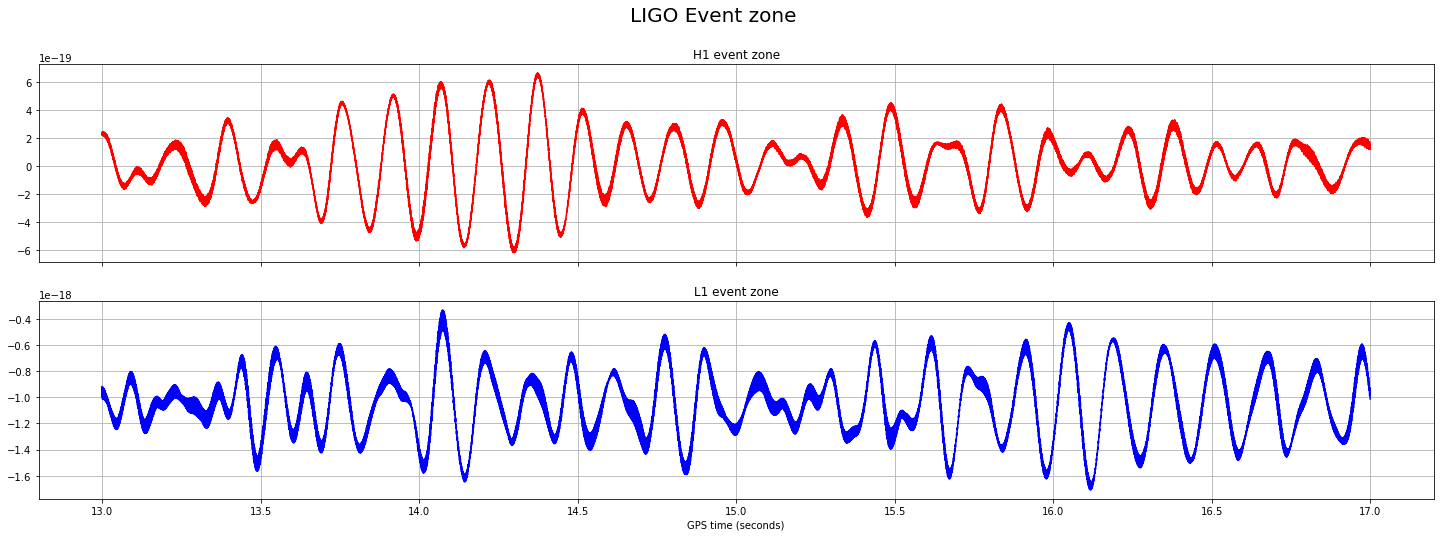

In [7]:
# Plot raw events
fig, axs = plt.subplots(2, sharex=True, figsize=(25,8))
fig.suptitle('LIGO Event zone',fontsize=20)
axs[0].plot(time_event, h1_event, color='red')
axs[1].plot(time_event, l1_event, color='blue')
axs[0].set_title('H1 event zone')
axs[1].set_title('L1 event zone')
axs[1].set_xlabel('GPS time (seconds)')
axs[0].grid()
axs[1].grid()

In [8]:
# Get silence (noise)
h1_silence = h1_s[(time > event_start + 2)]
l1_silence = l1_s[(time > event_start + 2)]
time_silence = time[(time > event_start + 2)]

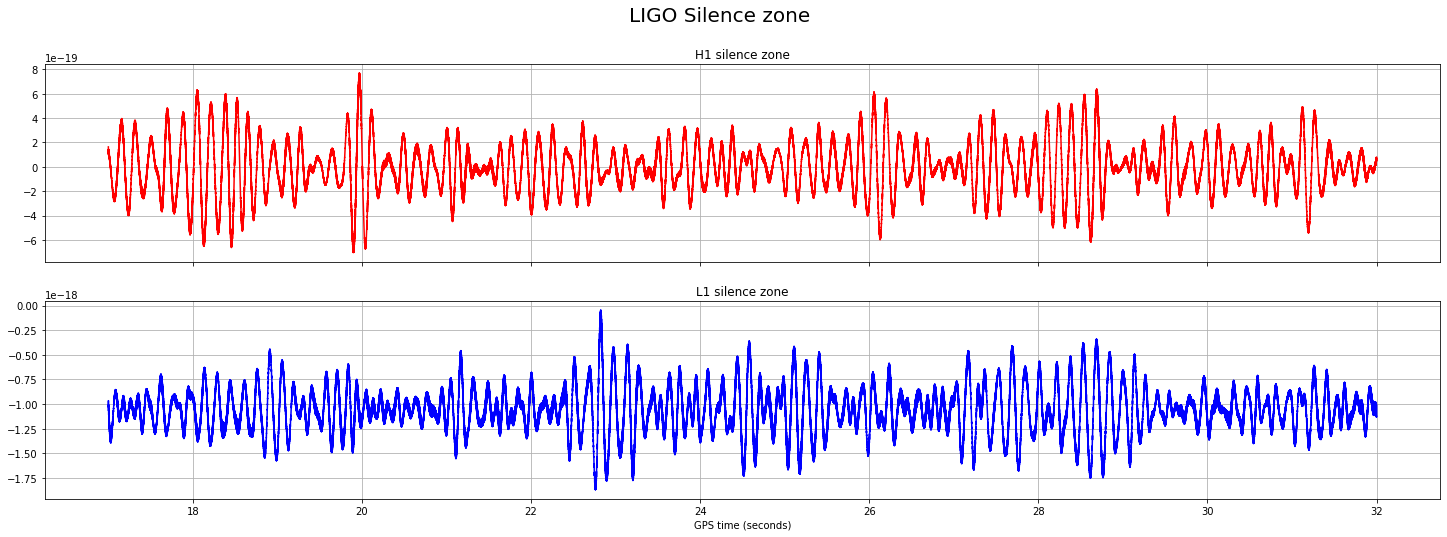

In [9]:
# Plot raw events
fig, axs = plt.subplots(2, sharex=True, figsize=(25,8))
fig.suptitle('LIGO Silence zone',fontsize=20)
axs[0].plot(time_silence, h1_silence, color='red')
axs[1].plot(time_silence, l1_silence, color='blue')
axs[0].set_title('H1 silence zone')
axs[1].set_title('L1 silence zone')
axs[1].set_xlabel('GPS time (seconds)')
axs[0].grid()
axs[1].grid()

# Estimating noise psd

In [10]:
from ej1.periodogram import periodogram
from ej1.per_averaging import periodogram_averaging
from ej1.per_smoothing import periodogram_smoothing

## Periodogram

In [11]:
def plot_periodogram(ax, fs, signal, window):
    f, per = periodogram(signal, window=window)
    f *= fs
    ax.loglog(f,per, label=window)
    ax.grid(axis='both', which='both')

Wall time: 384 ms


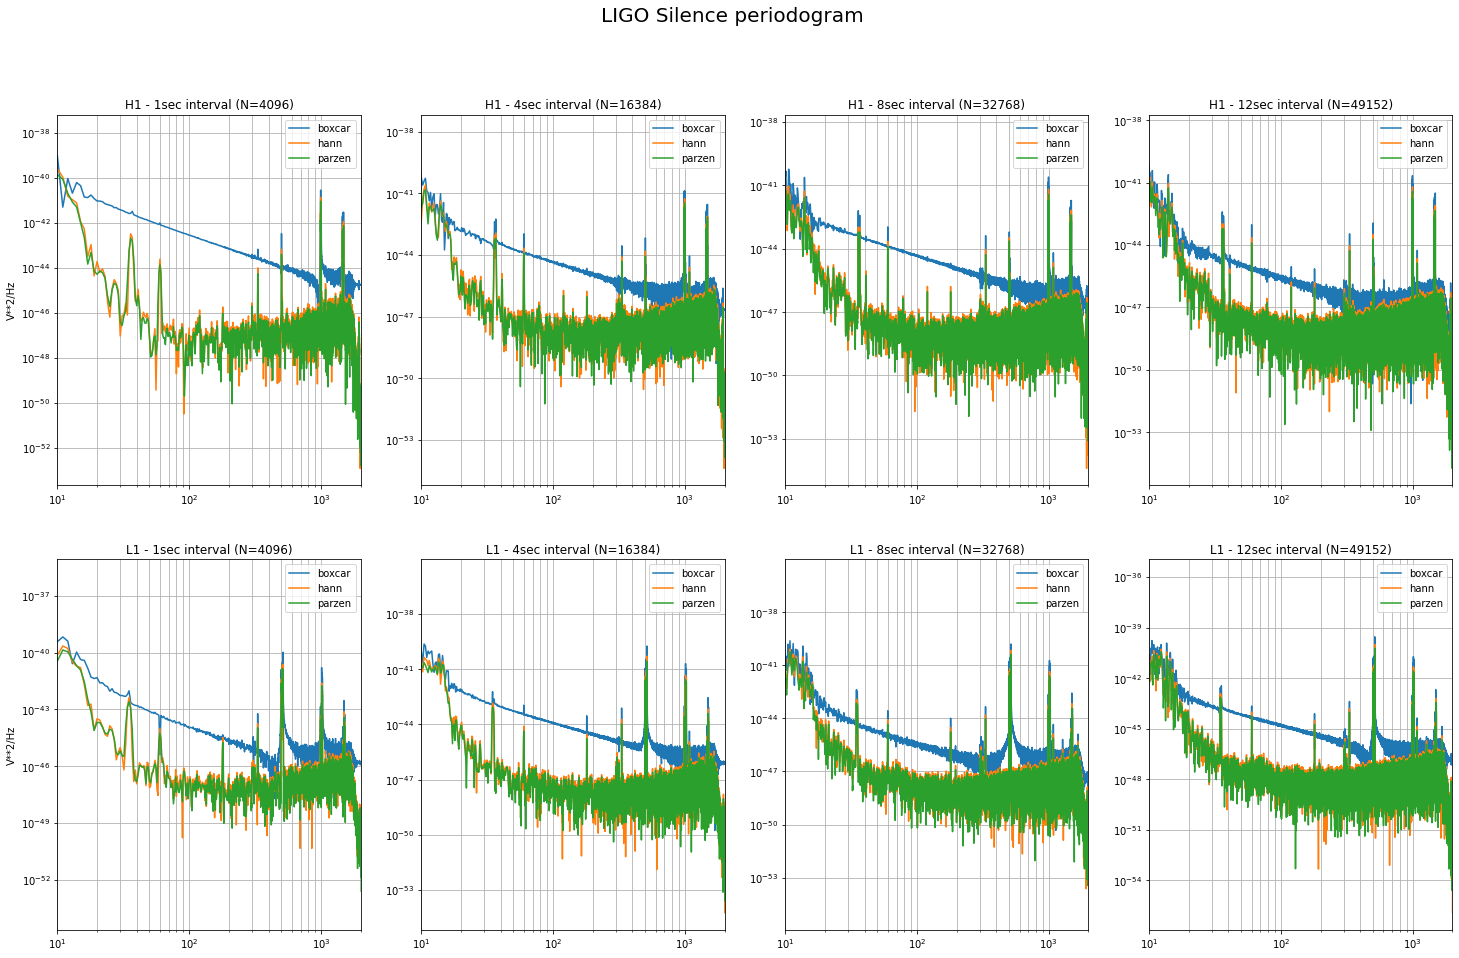

In [12]:
%%time
windows = ['boxcar', 'hann', 'parzen']
samples = [1,4,8,12]
signals = [h1_silence, l1_silence]

fig, axs = plt.subplots(2, 4, figsize=(25,15))
fig.suptitle('LIGO Silence periodogram', fontsize=20)
axs[0][0].set_ylabel('V**2/Hz')
axs[1][0].set_ylabel('V**2/Hz')
for i, s in enumerate(signals):
    for j,sample in enumerate(samples):
        for w in windows:
            plot_periodogram(axs[i][j], h1_fs, s[:int(sample*h1_fs)], w)
        tag = 'H1' if i == 0 else 'L1'
        axs[i][j].set_title(f'{tag} - {sample}sec interval (N={int(sample*h1_fs)})')
        axs[i][j].legend()
        axs[i][j].set_xlim(10,2000)  

## Periodogram averaging

In [13]:
def plot_periodogram_avg(ax, fs, signal, k, overlap):
    D = int(signal.shape[0] / k)
    L = int(D / (1-overlap))
    f, per = periodogram_averaging(signal, k, L)
    f *= fs
    ax.loglog(f,per, label=f'{o*100}% overlap')
    ax.grid(axis='both', which='both')

Wall time: 618 ms


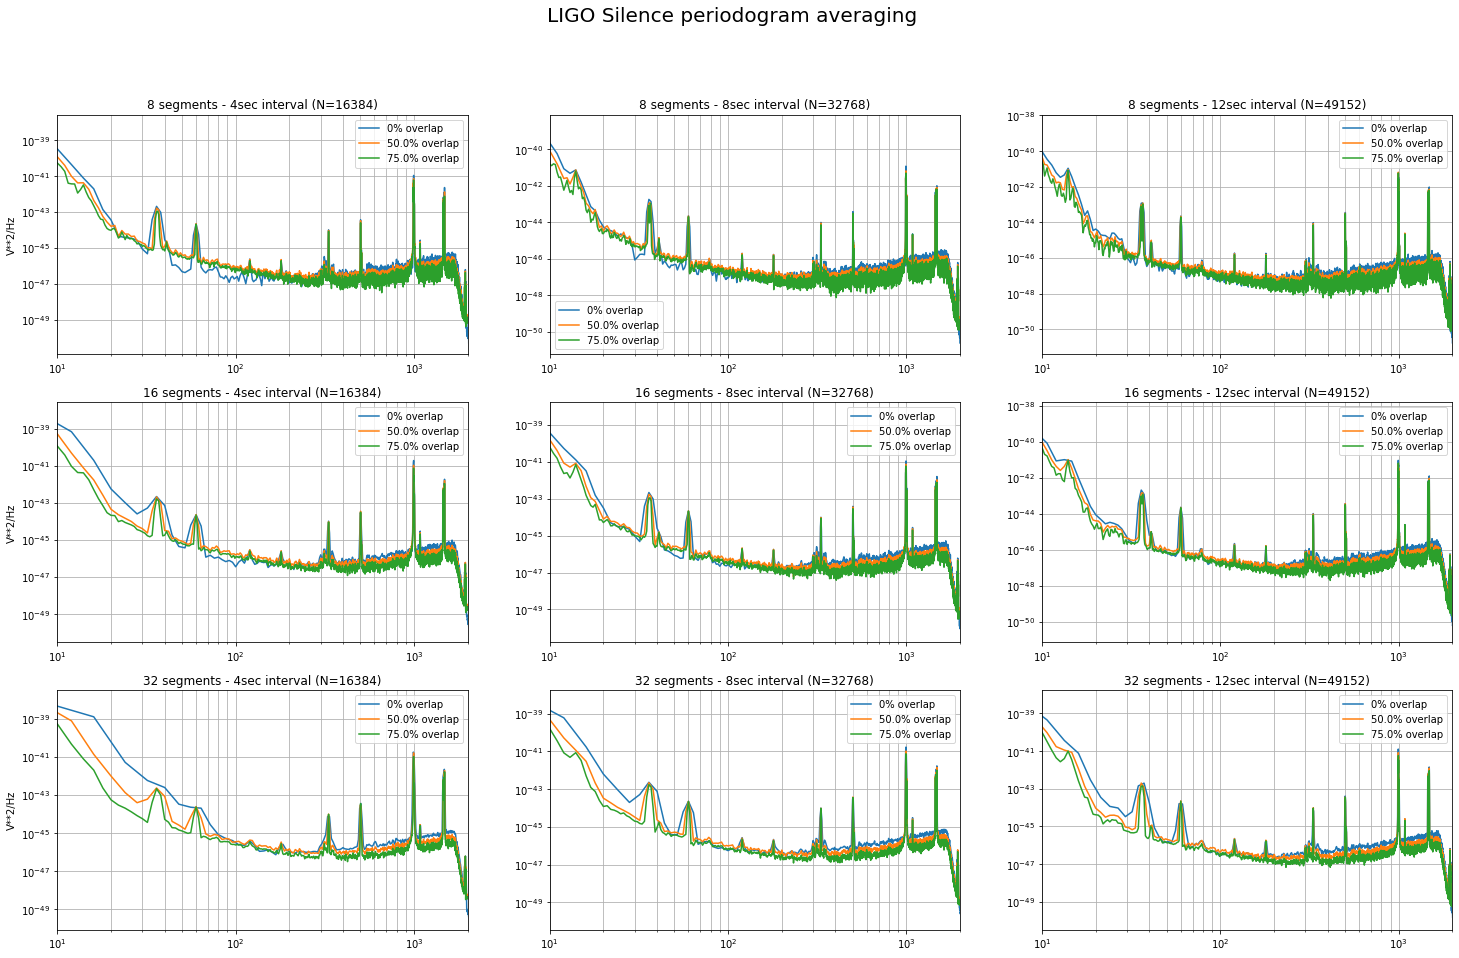

In [14]:
%%time
segments = [8, 16, 32]
samples = [4,8,12]
overlaps = [0,0.5, 0.75]

fig, axs = plt.subplots(3, 3, figsize=(25,15))
fig.suptitle('LIGO Silence periodogram averaging', fontsize=20)
axs[0][0].set_ylabel('V**2/Hz')
axs[1][0].set_ylabel('V**2/Hz')
axs[2][0].set_ylabel('V**2/Hz')

for i, k in enumerate(segments):
    for j,sample in enumerate(samples):
        for o in overlaps:
            plot_periodogram_avg(axs[i][j], h1_fs, h1_silence[:int(sample*h1_fs)], k, o)
        axs[i][j].set_title(f'{k} segments - {sample}sec interval (N={int(sample*h1_fs)})')
        axs[i][j].legend()
        axs[i][j].set_xlim(10,2000)        

## Periodogram smoothing

In [15]:
def plot_periodogram_smoothing(ax, fs, signal, L, window):
    f, per = periodogram_smoothing(signal, L, window=window, M=50)
    f *= fs
    ax.loglog(f,per, label=window)
    ax.grid(axis='both', which='both')

Wall time: 1min 6s


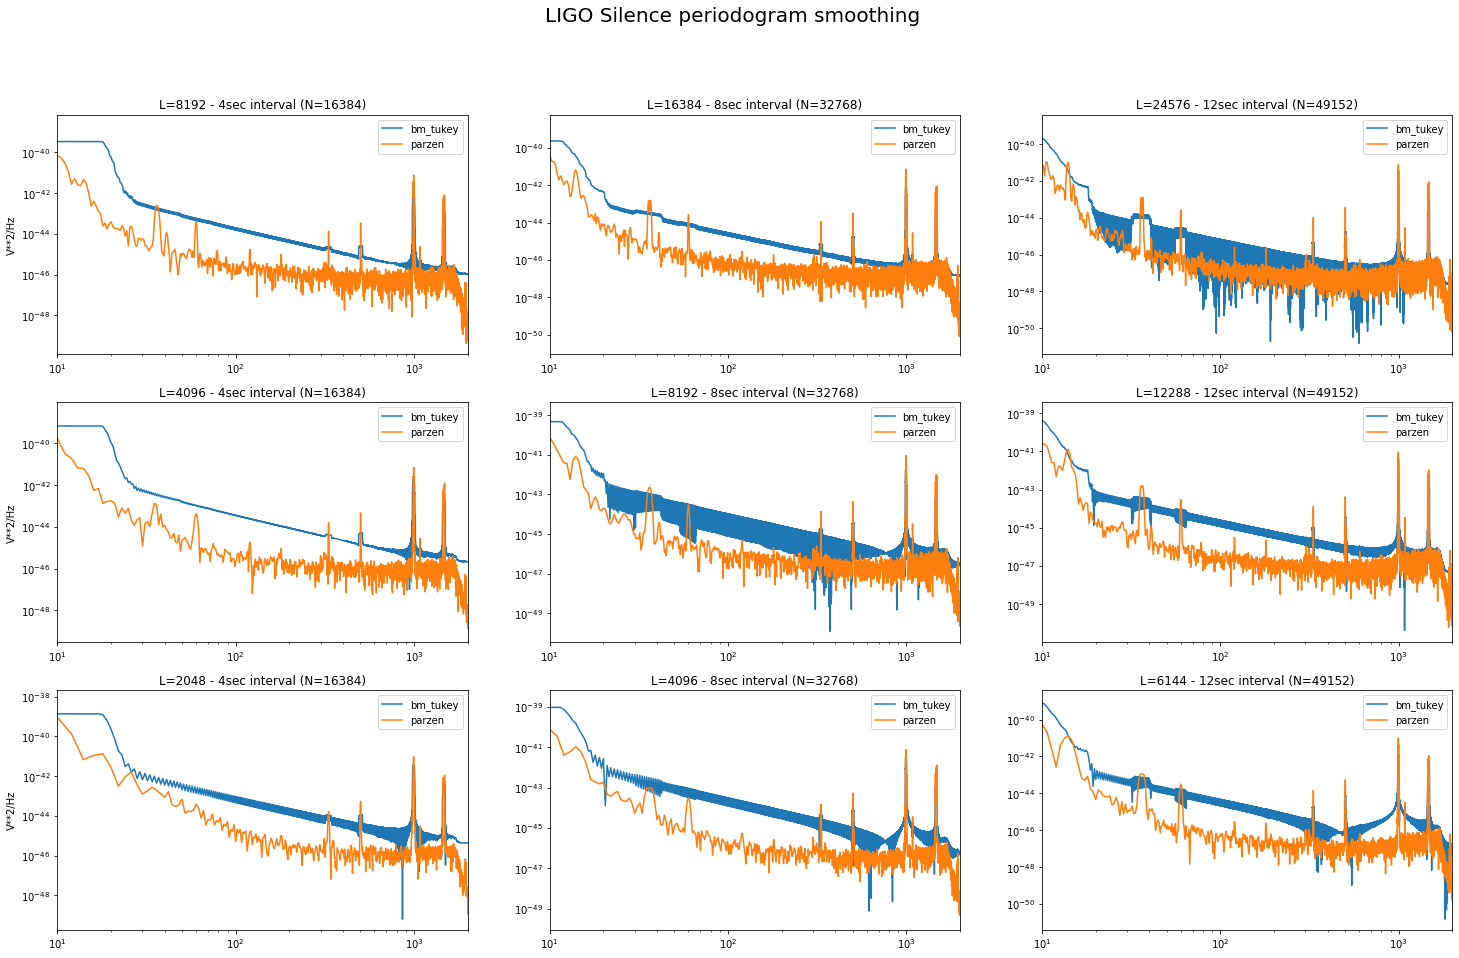

In [16]:
%%time
lengths = [2, 4, 8]
samples = [4,8,12] # seconds
windows = ['bm_tukey', 'parzen']

fig, axs = plt.subplots(3, 3, figsize=(25,15))
fig.suptitle('LIGO Silence periodogram smoothing', fontsize=20)
axs[0][0].set_ylabel('V**2/Hz')
axs[1][0].set_ylabel('V**2/Hz')
axs[2][0].set_ylabel('V**2/Hz')

for i, L in enumerate(lengths):
    for j,sample in enumerate(samples):
        for w in windows:
            plot_periodogram_smoothing(axs[i][j], h1_fs, h1_silence[:int(sample*h1_fs)], int(sample*h1_fs/L), w)
        axs[i][j].set_title(f'L={int(sample*h1_fs/L)} - {sample}sec interval (N={int(sample*h1_fs)})')
        axs[i][j].legend()
        axs[i][j].set_xlim(10,2000)

## Best psd estimation

In [17]:
# Best periodogram parameters
N = int(4*h1_fs)
window = 'parzen'

h1_per_f, h1_per_best = periodogram(h1_silence[:N], window=window)
l1_per_f, l1_per_best = periodogram(l1_silence[:N], window=window)

In [18]:
# Best PA model parameters
k = 16               # Segments
N = int(12*h1_fs)
overlap = 0.5

D = N // k
L = int(D / (1-overlap))
h1_pa_f, h1_pa_best = periodogram_averaging(h1_silence[:N], k, L)
l1_pa_f, l1_pa_best = periodogram_averaging(l1_silence[:N], k, L)

In [19]:
# Best PS model parameters
N = int(12*h1_fs)
L = int(N/4)
window = 'parzen'

h1_ps_f, h1_ps_best = periodogram_smoothing(h1_silence[:N], L, window=window)
l1_ps_f, l1_ps_best = periodogram_smoothing(l1_silence[:N], L, window=window)

In [20]:
import matplotlib.mlab as mlab

 # number of sample for the fast fourier transform:
NFFT = int(4 * h1_fs)           # Use 4 seconds of data for each fourier transform
NOVL = 1 * NFFT / 2     # The number of points of overlap between segments used in Welch averaging
psd_window = sps.tukey(NFFT, alpha=1./4)

Pxx_H1, freqs = mlab.psd(h1_silence[:NFFT], Fs=h1_fs, NFFT=NFFT,
                         window=psd_window, noverlap=NOVL)
Pxx_L1, freqs= mlab.psd(l1_silence[:NFFT], Fs=l1_fs, NFFT=NFFT, 
                        window=psd_window, noverlap=NOVL)

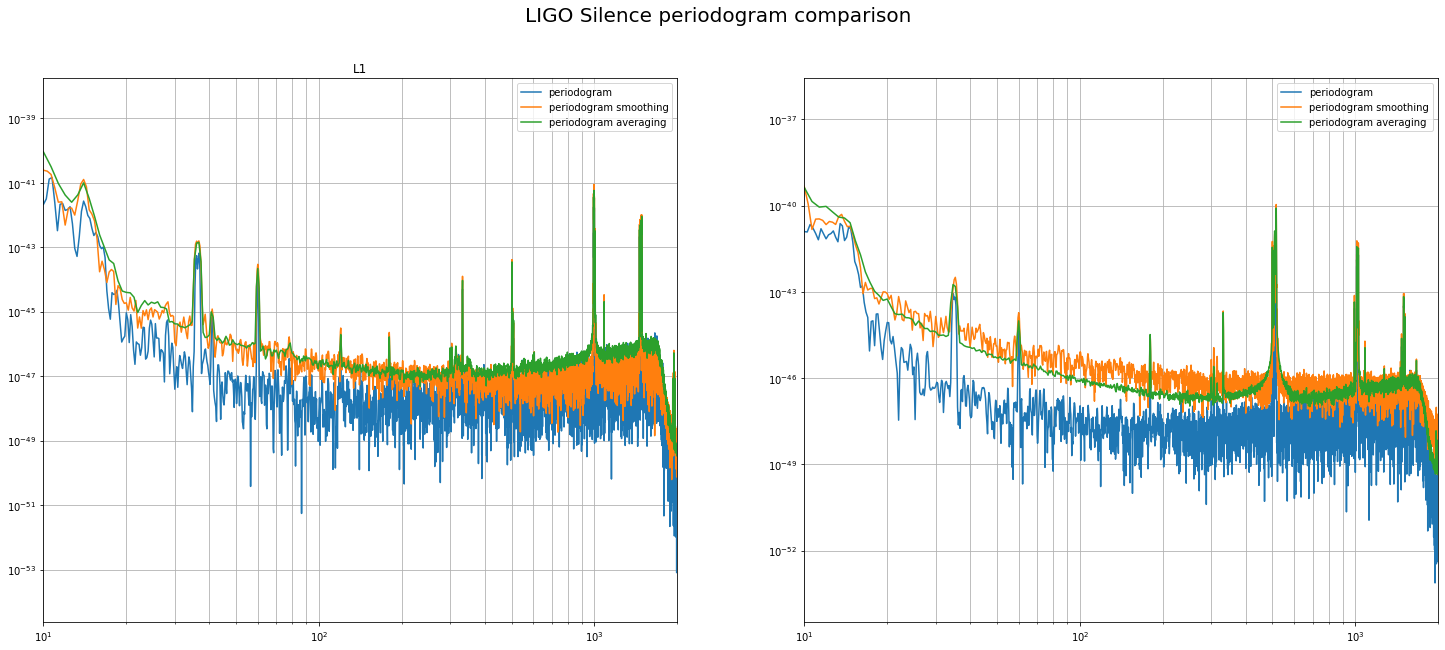

In [21]:
fig, axs = plt.subplots(1,2, figsize=(25,10))
fig.suptitle('LIGO Silence periodogram comparison', fontsize=20)

# Plotting H1
axs[0].loglog(h1_per_f*h1_fs, h1_per_best, label='periodogram')
axs[0].loglog(h1_ps_f*h1_fs, h1_ps_best, label='periodogram smoothing')
axs[0].loglog(h1_pa_f*h1_fs, h1_pa_best, label='periodogram averaging')

axs[0].set_xlim(10,2000)
axs[0].grid(axis='both', which='both')
axs[0].set_title('H1')
axs[0].legend()

# Plotting L1
axs[1].loglog(l1_per_f*l1_fs, l1_per_best, label='periodogram')
axs[1].loglog(l1_ps_f*l1_fs, l1_ps_best, label='periodogram smoothing')
axs[1].loglog(l1_pa_f*l1_fs, l1_pa_best, label='periodogram averaging')

axs[1].set_xlim(10,2000)
axs[1].grid(axis='both', which='both')
axs[0].set_title('L1')
axs[1].legend()

In [22]:
from ej2.whitenning import whiten, band_pass_filter
from scipy.interpolate import interp1d

# Generate interpolated spectrum
h1_interp_psd = interp1d(h1_pa_f*h1_fs, h1_pa_best, kind='linear')
l1_interp_psd = interp1d(l1_pa_f*l1_fs, l1_pa_best, kind='linear')

# Signal whitening
h1_whitened_signal = whiten(h1_event, h1_interp_psd, 1/h1_fs)
l1_whitened_signal = whiten(l1_event, l1_interp_psd, 1/l1_fs)

# Passband filter
h1_filtered_whitened_signal = band_pass_filter(h1_whitened_signal, h1_fs, [20,400])
l1_filtered_whitened_signal = band_pass_filter(l1_whitened_signal, l1_fs, [20,400])

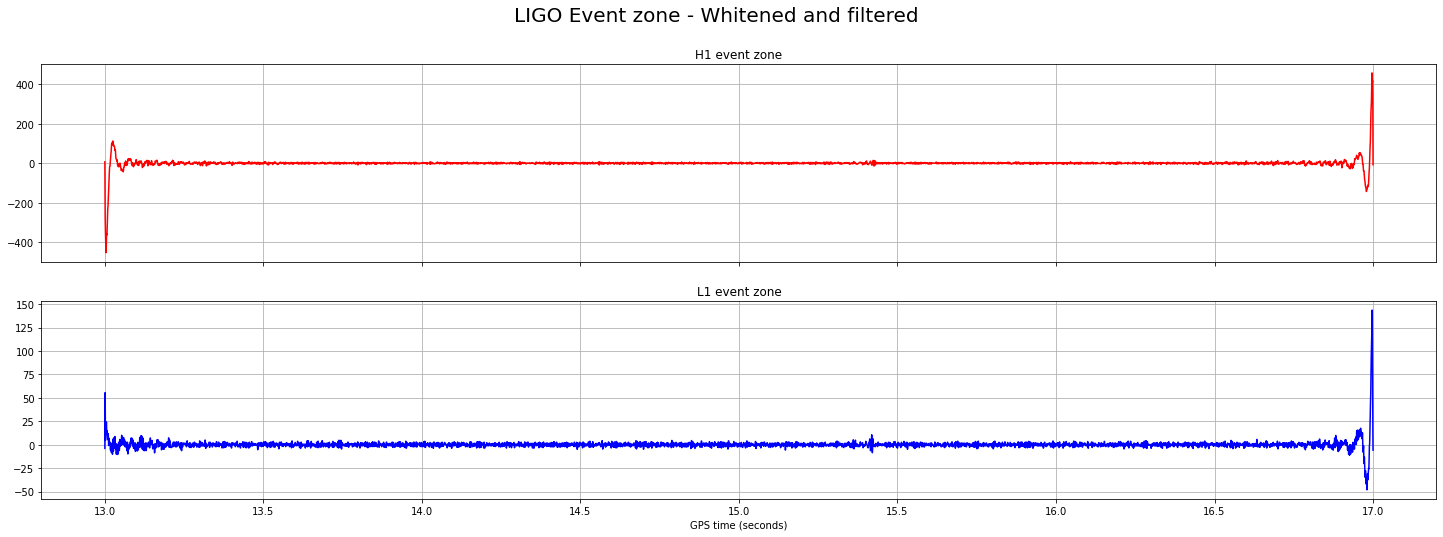

In [23]:
# Plot H1 and L1 signals
fig, axs = plt.subplots(2, sharex=True, figsize=(25,8))
fig.suptitle('LIGO Event zone - Whitened and filtered',fontsize=20)
axs[0].plot(time_event, h1_filtered_whitened_signal, color='red')
axs[1].plot(time_event, l1_filtered_whitened_signal, color='blue')
axs[0].set_title('H1 event zone')
axs[1].set_title('L1 event zone')
axs[1].set_xlabel('GPS time (seconds)')
axs[0].grid()
axs[1].grid()

In [24]:
# Shift event
h1_shifted_event = np.roll(h1_filtered_whitened_signal, h1_filtered_whitened_signal.shape[0] // 2)
l1_shifted_event = np.roll(l1_filtered_whitened_signal, l1_filtered_whitened_signal.shape[0] // 2)

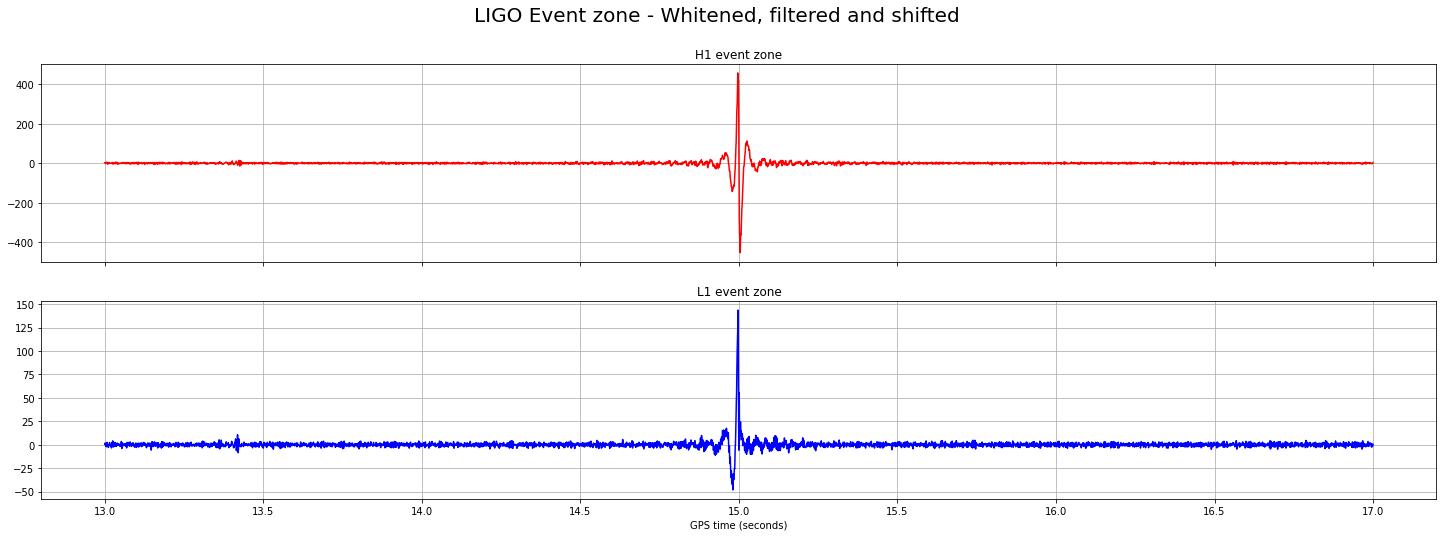

In [25]:
# Plot raw events
fig, axs = plt.subplots(2, sharex=True, figsize=(25,8))
fig.suptitle('LIGO Event zone - Whitened, filtered and shifted',fontsize=20)
axs[0].plot(time_event, h1_shifted_event, color='red')
axs[1].plot(time_event, l1_shifted_event, color='blue')
axs[0].set_title('H1 event zone')
axs[1].set_title('L1 event zone')
axs[1].set_xlabel('GPS time (seconds)')
axs[0].grid()
axs[1].grid()

In [26]:
import scipy.io.wavfile
# Scale signal to fit WAV format
h1_shifted_event_scaled = np.int16(h1_shifted_event/np.max(np.abs(h1_shifted_event)) * 32767 * 0.9)
l1_shifted_event_scaled = np.int16(l1_shifted_event/np.max(np.abs(l1_shifted_event)) * 32767 * 0.9)

# Save WAV files
scipy.io.wavfile.write('./output/h1_event.wav', int(h1_fs), h1_shifted_event_scaled)
scipy.io.wavfile.write('./output/l1_event.wav', int(l1_fs), l1_shifted_event_scaled)

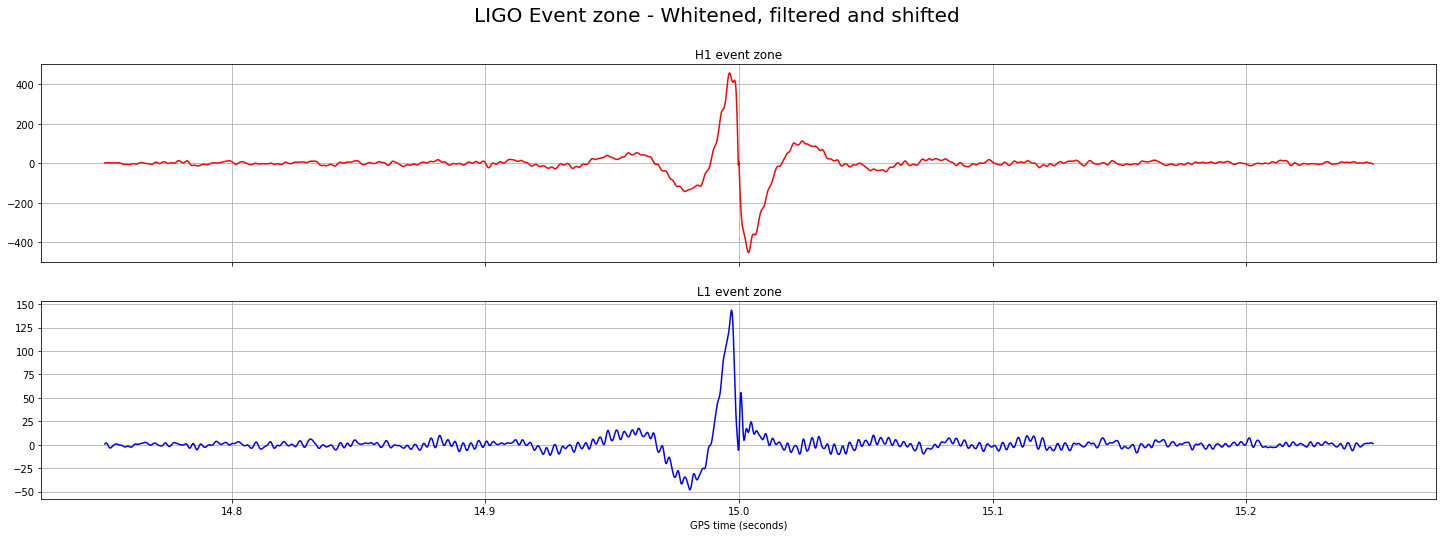

In [27]:
# Plot zoomed events
fig, axs = plt.subplots(2, sharex=True, figsize=(25,8))
fig.suptitle('LIGO Event zone - Whitened, filtered and shifted',fontsize=20)
axs[0].plot(time_event[(time_event >= 14.75) & (time_event <= 15.25)], h1_shifted_event[(time_event >= 14.75) & (time_event <= 15.25)], color='red')
axs[1].plot(time_event[(time_event >= 14.75) & (time_event <= 15.25)], l1_shifted_event[(time_event >= 14.75) & (time_event <= 15.25)], color='blue')
axs[0].set_title('H1 event zone')
axs[1].set_title('L1 event zone')
axs[1].set_xlabel('GPS time (seconds)')
axs[0].grid()
axs[1].grid()